In [58]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-2B-Instruct",
    'qwen2-2b-pointing/checkpoint-500/',
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="cuda:0",
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

In [59]:
model

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionFlashAttention2(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): S

# Generate dataset

In [78]:
from datasets import load_dataset

data = load_dataset("allenai/pixmo-pointing", split="train")

In [79]:
import json
with open('successful_urls.json', 'r', encoding='utf-8') as f:
    mapping = json.load(f)
mapping = {item['url']: item['path'] for item in mapping}

In [80]:
data

Dataset({
    features: ['image_url', 'image_sha256', 'points', 'label'],
    num_rows: 2057090
})

In [81]:
def url_to_path(example):
    if example['image_url'] in mapping:
        example['image_url'] = mapping[example['image_url']]
    else:
        example['image_url'] = None
    return example

In [82]:
data = data.map(url_to_path)

In [83]:
data = data.filter(lambda example: example["image_url"])

In [84]:
len(data)

1679490

In [85]:
import json
import random
from tqdm import tqdm


# Define question templates
QUESTION_TEMPLATES = [
    "Where are the {label} in the image?",
    "Can you point out the {label} in this picture?",
    "Show the location of {label} in the image.",
    "What is the position of the {label} here?",
    "Can you locate the {label} in this image?",
    "Please identify the {label} in the picture.",
    "Point out where the {label} are in the image.",
    "Where exactly are the {label} situated?",
    "Mark the {label} in this image.",
    "Find and point to the {label} in the image."
]

# Function to generate HTML-like points format
def generate_points_format(points, label):
    if not points:
        return f'<points alt="{label.strip()}">There are none.</points>'
    
    points_attributes = []
    for idx, point in enumerate(points):
        x = round(point['x'], 2)
        y = round(point['y'], 2)
        points_attributes.append(f'x{idx}="{x}"')
        points_attributes.append(f'y{idx}="{y}"')
    
    points_str = " ".join(points_attributes)
    return f'<points {points_str} alt="{label.strip()}">{label.strip()}</points>'

# Function to generate dataset with questions and answers
def generate_dataset(dataset):
    generated_data = []
    for entry in tqdm(dataset):
        label = entry['label']
        points = entry['points']
        image_url = entry['image_url']

        question = random.choice(QUESTION_TEMPLATES).format(label=label.strip())
        answer = generate_points_format(points, label)
        generated_data.append({
            "question": question,
            "answer": answer,
            "image_url": image_url
        })
    return generated_data


In [86]:
generated_dataset = generate_dataset(data)

100%|██████████| 1679490/1679490 [02:46<00:00, 10069.92it/s]


In [93]:
from datasets import Dataset

dataset = Dataset.from_dict({
    "question": [item["question"] for item in generated_dataset],
    "answer": [item["answer"] for item in generated_dataset],
    "image_url": [item["image_url"] for item in generated_dataset]
})

dataset

Dataset({
    features: ['question', 'answer', 'image_url'],
    num_rows: 1679490
})

In [98]:
dataset['answer'][:50]

['<points x0="91.23" y0="31.64" x1="98.74" y1="29.58" x2="87.64" y2="26.84" x3="82.91" y3="36.7" x4="92.36" y4="41.22" x5="87.64" y5="49.71" x6="81.88" y6="46.15" alt="balloons">balloons</points>',
 '<points x0="28.83" y0="17.26" alt="wall">wall</points>',
 '<points x0="82.7" y0="96.27" alt="floor">floor</points>',
 '<points x0="25.65" y0="93.12" x1="30.58" y1="81.07" alt="shoes">shoes</points>',
 '<points alt="feet">There are none.</points>',
 '<points x0="49.19" y0="61.22" x1="48.47" y1="27.94" x2="66.66" y2="27.25" x3="38.81" y3="40.54" alt="hats">hats</points>',
 '<points x0="75.4" y0="66.97" x1="26.37" y1="64.5" x2="71.19" y2="43.0" alt="nametags">nametags</points>',
 '<points x0="67.49" y0="66.83" x1="55.46" y1="48.75" x2="59.16" y2="36.43" x3="41.27" y3="35.47" x4="26.88" y4="37.66" x5="49.6" y5="28.76" x6="42.82" y6="27.12" x7="51.04" y7="39.3" x8="30.48" y8="50.67" x9="18.35" y9="45.47" x10="67.08" y10="66.28" x11="50.83" y11="66.01" x12="58.34" y12="57.38" alt="glasses">glass

In [99]:
dataset.save_to_disk("data/generated_dataset")

Saving the dataset (1/1 shards): 100%|██████████| 1679490/1679490 [00:00<00:00, 1993024.60 examples/s]


In [100]:
len(dataset)

1679490

# Eval

In [60]:
from datasets import load_from_disk

dataset = load_from_disk("data/generated_dataset")

In [202]:
idx = -11025
dataset[idx]

{'question': 'Mark the dark storm clouds in this image.',
 'answer': '<points x0="37.77" y0="3.86" x1="48.05" y1="8.31" x2="66.84" y2="6.38" x3="98.68" y3="16.61" alt="dark storm clouds">dark storm clouds</points>',
 'image_url': 'downloaded_images/b42e499c982323d4bba100bc48e95f23.jpg'}

In [208]:
system_message = """You are a Vision Language Model specialized in pointing to searched object
    Poiniting uses HTML-like format. (x,y) coordinates are scaled to 0-100. For a single point, the format is:
<point x="10.0" y="10.0" alt="alt text">Inline text</point>
For multiple points the format is:
<points x1="10.0" y1="10.0" x2="20.0" y1="20.0" ...  alt="alt text">Inline text</points>
It is also possble that searched object is not presented"""
messages = [
    {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": system_message
            }
        ],
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": dataset[idx]['image_url'],
            },
            {"type": "text", "text": "what color is the sky in the image?"},
        ],
    }
]
image_inputs, video_inputs = process_vision_info(messages)
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


['<points alt="sky color is the sky in the image">There are none.</points>']


In [204]:
import xml.etree.ElementTree as ET

# Your HTML-like string
html_str = '<points x0="11.96" y0="49.0" alt="trashcan">trashcan</points>'

# Parse the string
element = ET.fromstring(output_text[0])

# Extract attributes
x0 = float(element.attrib.get('x0'))
y0 = float(element.attrib.get('y0'))
alt = element.attrib.get('alt')

# Extract inner text
inner_text = element.text

# Print the values
print(f"x0: {x0}")
print(f"y0: {y0}")
print(f"alt: {alt}")
print(f"Inner text: {inner_text}")


x0: 51.17
y0: 11.17
alt: dark Storm clouds
Inner text: dark Storm clouds


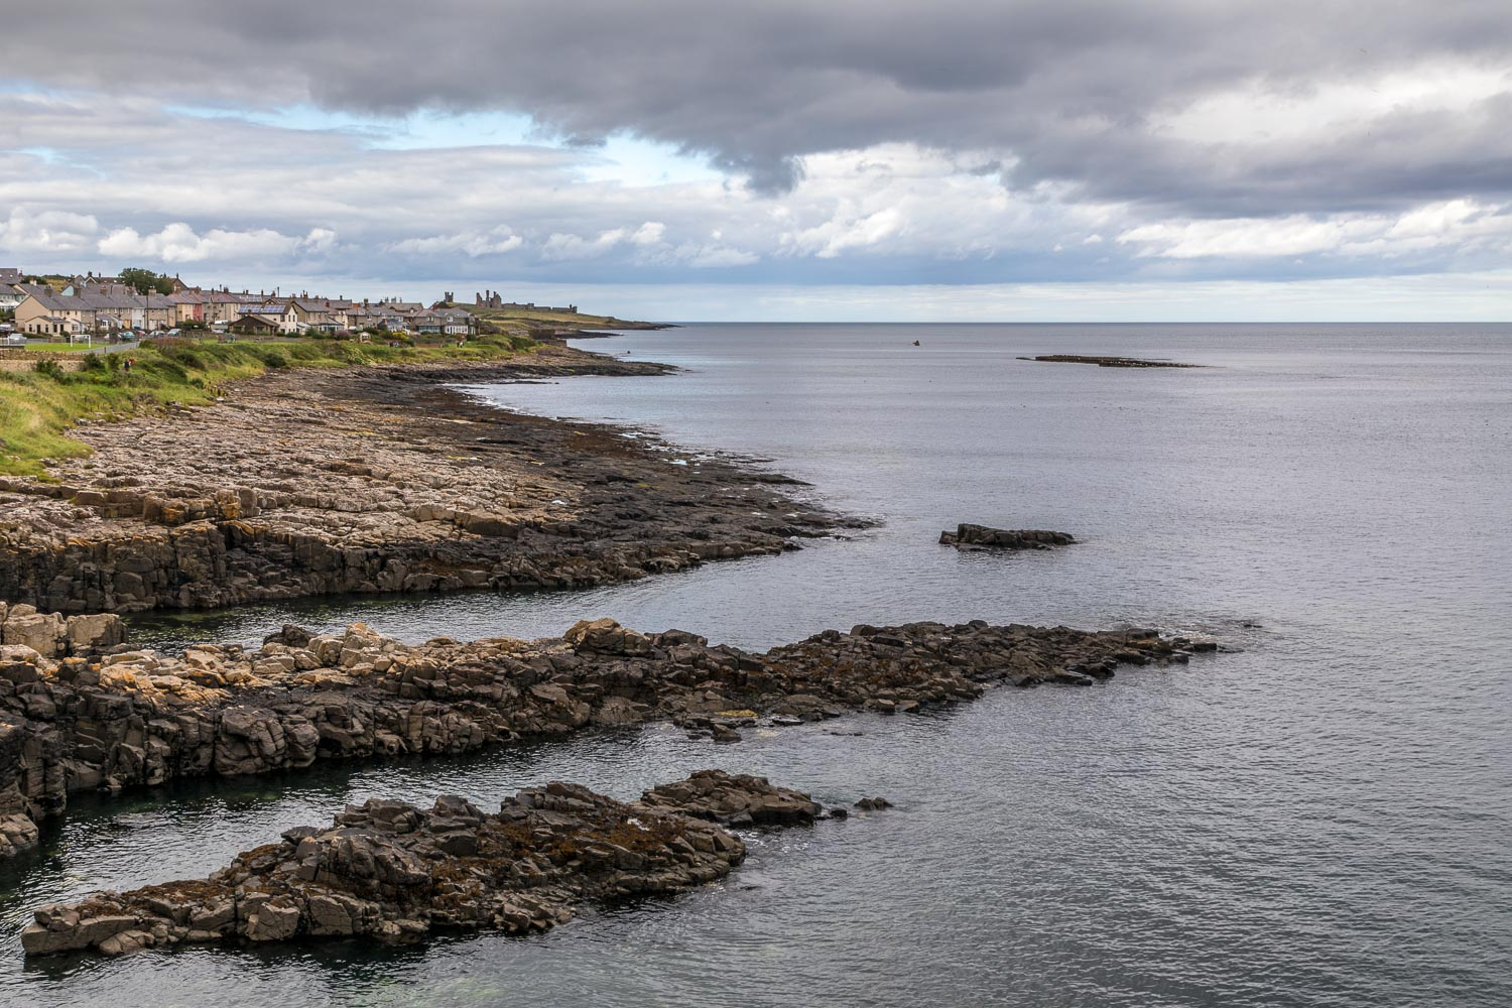

In [ ]:
image_inputs[0]

In [206]:
from PIL import Image, ImageDraw
draw = ImageDraw.Draw(image_inputs[0])

point_position = (x0/100*image_inputs[0].size[0], y0/100*image_inputs[0].size[1])  # X, Y coordinates

point_color = (255, 0, 0)  # RGB color, for example, red

# Define the radius of the point
point_radius = 10

# Draw the point as a small ellipse/circle
draw.ellipse(
   [
       (point_position[0] - point_radius, point_position[1] - point_radius),
       (point_position[0] + point_radius, point_position[1] + point_radius)
   ],
   fill=point_color,
   outline=point_color
)


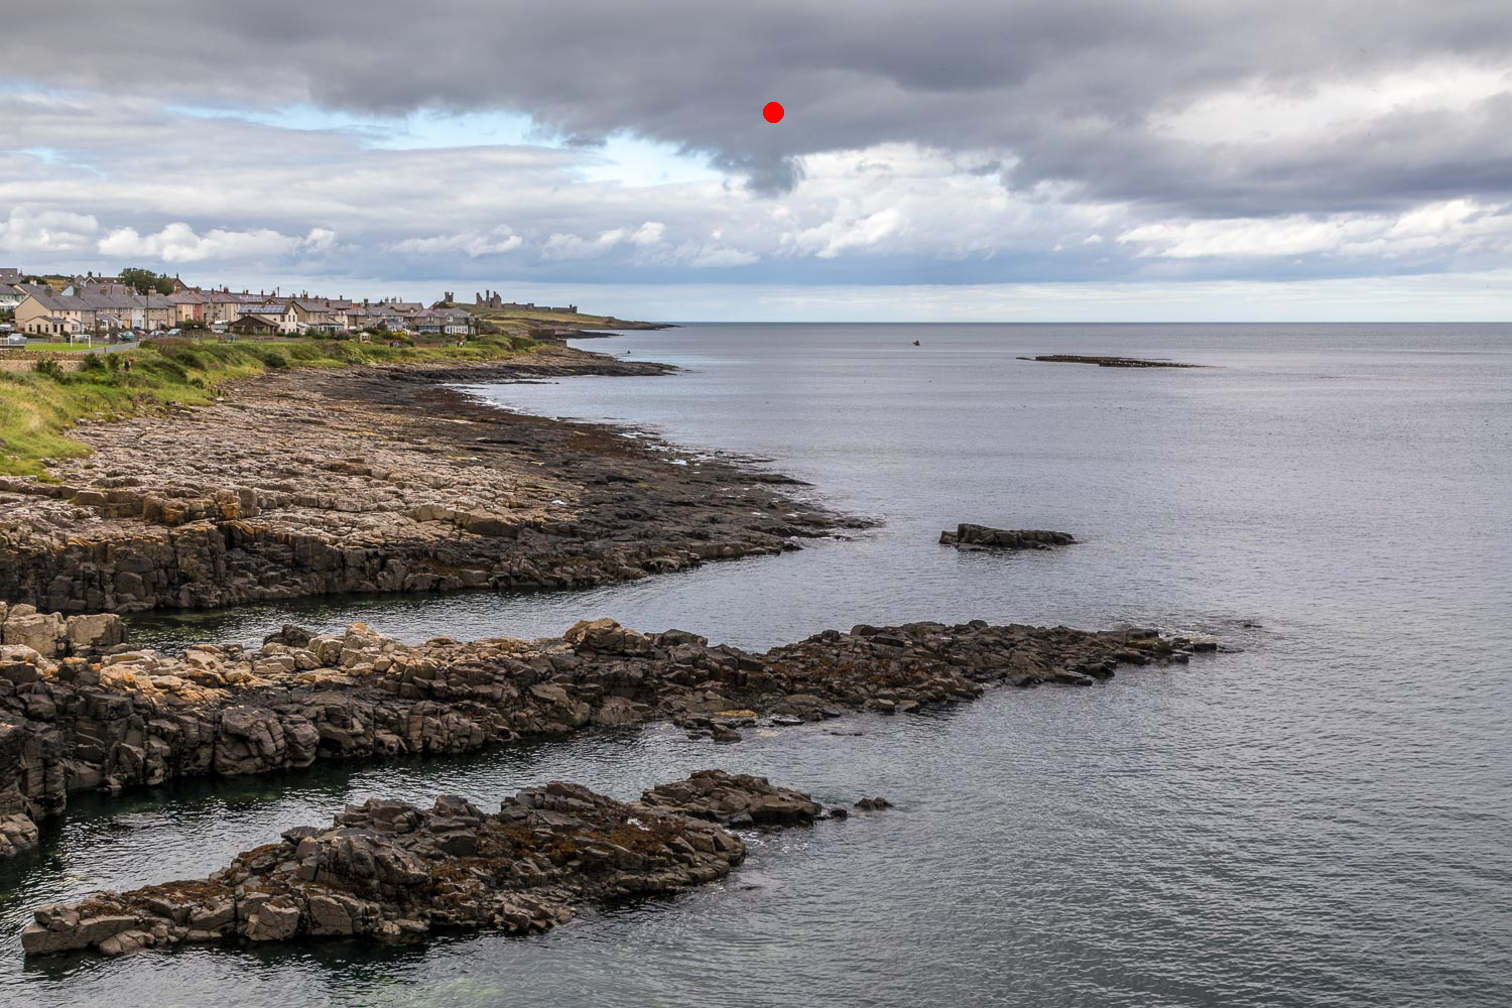

In [ ]:
image_inputs[0]

In [185]:
success = 0
from tqdm import tqdm
for i in tqdm(range(100000, 100100)):
    system_message = """You are a Vision Language Model specialized in pointing to searched object
    Poiniting uses HTML-like format. (x,y) coordinates are scaled to 0-100. For a single point, the format is:
<point x="10.0" y="10.0" alt="alt text">Inline text</point>
For multiple points the format is:
<points x1="10.0" y1="10.0" x2="20.0" y1="20.0" ...  alt="alt text">Inline text</points>
It is also possble that searched object is not presented"""
    messages = [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": dataset[idx]['image_url'],
                },
                {"type": "text", "text": dataset[idx]['question']},
            ],
        }
    ]
    image_inputs, video_inputs = process_vision_info(messages)
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    print(output_text)
    try:
        import xml.etree.ElementTree as ET

        # Your HTML-like string
        html_str = '<points x0="11.96" y0="49.0" alt="trashcan">trashcan</points>'

        # Parse the string
        element = ET.fromstring(output_text[0])

        # Extract attributes
        x0 = float(element.attrib.get('x0'))
        y0 = float(element.attrib.get('y0'))
        alt = element.attrib.get('alt')

        # Extract inner text
        inner_text = element.text
        success+=1
    except:
        continue

success/100

  1%|          | 1/100 [00:01<02:51,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  2%|▏         | 2/100 [00:03<02:49,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  3%|▎         | 3/100 [00:05<02:47,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  4%|▍         | 4/100 [00:06<02:46,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  5%|▌         | 5/100 [00:08<02:44,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  6%|▌         | 6/100 [00:10<02:42,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  7%|▋         | 7/100 [00:12<02:41,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  8%|▊         | 8/100 [00:14<02:44,  1.79s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


  9%|▉         | 9/100 [00:15<02:41,  1.77s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 10%|█         | 10/100 [00:17<02:38,  1.76s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 11%|█         | 11/100 [00:19<02:35,  1.75s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 12%|█▏        | 12/100 [00:20<02:33,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 13%|█▎        | 13/100 [00:22<02:31,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 14%|█▍        | 14/100 [00:24<02:29,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 15%|█▌        | 15/100 [00:26<02:27,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 16%|█▌        | 16/100 [00:27<02:25,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 17%|█▋        | 17/100 [00:29<02:23,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 18%|█▊        | 18/100 [00:31<02:22,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 19%|█▉        | 19/100 [00:33<02:20,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 20%|██        | 20/100 [00:34<02:18,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 21%|██        | 21/100 [00:36<02:16,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 22%|██▏       | 22/100 [00:38<02:15,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 23%|██▎       | 23/100 [00:40<02:13,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 24%|██▍       | 24/100 [00:41<02:11,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 25%|██▌       | 25/100 [00:43<02:09,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 26%|██▌       | 26/100 [00:45<02:07,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 27%|██▋       | 27/100 [00:46<02:06,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 28%|██▊       | 28/100 [00:48<02:04,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 29%|██▉       | 29/100 [00:50<02:02,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 30%|███       | 30/100 [00:52<02:01,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 31%|███       | 31/100 [00:53<01:59,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 32%|███▏      | 32/100 [00:55<02:00,  1.78s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 33%|███▎      | 33/100 [00:57<01:58,  1.76s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 34%|███▍      | 34/100 [00:59<01:55,  1.75s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 35%|███▌      | 35/100 [01:00<01:53,  1.75s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 36%|███▌      | 36/100 [01:02<01:51,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 37%|███▋      | 37/100 [01:04<01:49,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 38%|███▊      | 38/100 [01:06<01:47,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 39%|███▉      | 39/100 [01:07<01:45,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 40%|████      | 40/100 [01:09<01:43,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 41%|████      | 41/100 [01:11<01:42,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 42%|████▏     | 42/100 [01:13<01:40,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 43%|████▎     | 43/100 [01:14<01:38,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 44%|████▍     | 44/100 [01:16<01:37,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 45%|████▌     | 45/100 [01:18<01:35,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 46%|████▌     | 46/100 [01:19<01:33,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 47%|████▋     | 47/100 [01:21<01:31,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 48%|████▊     | 48/100 [01:23<01:29,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 49%|████▉     | 49/100 [01:25<01:28,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 50%|█████     | 50/100 [01:26<01:26,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 51%|█████     | 51/100 [01:28<01:24,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 52%|█████▏    | 52/100 [01:30<01:22,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 53%|█████▎    | 53/100 [01:32<01:21,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 54%|█████▍    | 54/100 [01:33<01:19,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 55%|█████▌    | 55/100 [01:35<01:17,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 56%|█████▌    | 56/100 [01:37<01:16,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 57%|█████▋    | 57/100 [01:38<01:14,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 58%|█████▊    | 58/100 [01:40<01:13,  1.76s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 59%|█████▉    | 59/100 [01:42<01:11,  1.75s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 60%|██████    | 60/100 [01:44<01:09,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 61%|██████    | 61/100 [01:45<01:07,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 62%|██████▏   | 62/100 [01:47<01:06,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 63%|██████▎   | 63/100 [01:49<01:04,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 64%|██████▍   | 64/100 [01:51<01:02,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 65%|██████▌   | 65/100 [01:52<01:00,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 66%|██████▌   | 66/100 [01:54<00:58,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 67%|██████▋   | 67/100 [01:56<00:57,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 68%|██████▊   | 68/100 [01:58<00:55,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 69%|██████▉   | 69/100 [01:59<00:53,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 70%|███████   | 70/100 [02:01<00:52,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 71%|███████   | 71/100 [02:03<00:50,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 72%|███████▏  | 72/100 [02:05<00:48,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 73%|███████▎  | 73/100 [02:06<00:46,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 74%|███████▍  | 74/100 [02:08<00:45,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 75%|███████▌  | 75/100 [02:10<00:43,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 76%|███████▌  | 76/100 [02:11<00:41,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 77%|███████▋  | 77/100 [02:13<00:39,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 78%|███████▊  | 78/100 [02:15<00:38,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 79%|███████▉  | 79/100 [02:17<00:36,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 80%|████████  | 80/100 [02:18<00:34,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 81%|████████  | 81/100 [02:20<00:32,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 82%|████████▏ | 82/100 [02:22<00:31,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 83%|████████▎ | 83/100 [02:24<00:29,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 84%|████████▍ | 84/100 [02:25<00:27,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 85%|████████▌ | 85/100 [02:27<00:25,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 86%|████████▌ | 86/100 [02:29<00:24,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 87%|████████▋ | 87/100 [02:31<00:22,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 88%|████████▊ | 88/100 [02:32<00:20,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 89%|████████▉ | 89/100 [02:34<00:19,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 90%|█████████ | 90/100 [02:36<00:17,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 91%|█████████ | 91/100 [02:37<00:15,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 92%|█████████▏| 92/100 [02:39<00:13,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 93%|█████████▎| 93/100 [02:41<00:12,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 94%|█████████▍| 94/100 [02:43<00:10,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 95%|█████████▌| 95/100 [02:44<00:08,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 96%|█████████▌| 96/100 [02:46<00:06,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 97%|█████████▋| 97/100 [02:48<00:05,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 98%|█████████▊| 98/100 [02:50<00:03,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


 99%|█████████▉| 99/100 [02:51<00:01,  1.73s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]

['<points x0="54.15" y0="94.15" alt="grassy">grassy</points>']


1.0